# Práctica 3: Clasificación Jerárquica
## Opción 2: Comparación de métodos

### Objetivo
El objetivo de esta práctica es introducir y aplicar los conceptos de **clasificación jerárquica**, utilizando al menos **dos algoritmos** ya existentes en las bibliotecas indicadas, y **al menos tres problemas de clasificación jerárquica**. Posteriormente, compararemos sus resultados y expondremos las conclusiones más relevantes.

En este notebook se realiza:
1. La **carga y preparación** de varios datasets jerárquicos (obtenidos de repositorios recomendados).
2. La **aplicación de dos métodos** de clasificación jerárquica (SVM y Random Forest) por medio de la biblioteca `sklearn-hierarchical-classification`.
3. La **evaluación y comparación** de los resultados.
4. La elaboración de **conclusiones** sobre el rendimiento y las características de cada método.

## 1. Instalación de bibliotecas necesarias
Se requiere instalar la biblioteca `sklearn-hierarchical-classification` (u otras equivalentes), así como clonar el repositorio que contiene los datasets utilizados.

In [1]:
!pip install git+https://github.com/globality-corp/sklearn-hierarchical-classification.git

  Cloning https://github.com/globality-corp/sklearn-hierarchical-classification.git to /tmp/pip-req-build-_vrlnayx
  Running command git clone --filter=blob:none --quiet https://github.com/globality-corp/sklearn-hierarchical-classification.git /tmp/pip-req-build-_vrlnayx
  Resolved https://github.com/globality-corp/sklearn-hierarchical-classification.git to commit 1de19f782d992a82dace895f9c24a0fc074baeeb
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn-hierarchical-classification: filename=sklearn_hierarchical_classification-1.3.2-py3-none-any.whl size=22883 sha256=155a5a3527004faca00a2e46879a7ee82e57d98c6b68a7f89b81ced6a4bbbdc1
  Stored in directory: /tmp/pip-ephem-wheel-cache-_7b5sp93/wheels/ba/80/9f/fed09501afa17cb8e77b237b97de493a339b405e98025cc8ac
Successfully built sklearn-hierarchical-classification


In [2]:
!git clone https://github.com/geantrindade/TEsHierarchicalDatasets.git

Cloning into 'TEsHierarchicalDatasets'...
remote: Enumerating objects: 60, done.
remote: Total 60 (delta 0), reused 0 (delta 0), pack-reused 60 (from 1)
Receiving objects: 100% (60/60), 44.67 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (44/44), done.
Updating files: 100% (46/46), done.


## 2. Importación de librerías y definición de funciones
A continuación, importamos las librerías y definimos las funciones auxiliares:
- **Preprocesamiento de datos** (imputación y normalización)
- **Creación de la jerarquía de clases** a partir de las etiquetas
- **Cálculo de métricas jerárquicas** (precisión, recall, F1 jerárquicos)
- **Entrenamiento y evaluación** de los clasificadores jerárquicos
- **Visualización** de la jerarquía y comparación de resultados

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn_hierarchical_classification.classifier import HierarchicalClassifier
from sklearn_hierarchical_classification.constants import ROOT
from sklearn.ensemble import RandomForestClassifier
import networkx as nx
from sklearn.feature_selection import SelectKBest, f_classif

# Función para preprocesar el dataset
def preprocess_dataset(X, y, test_size=0.25, random_state=42):
    """Preprocesamiento: split, imputación y estandarización."""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Imputar valores perdidos
    imputer = SimpleImputer(strategy="mean")
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Estandarizar
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Selección de características (top k basadas en ANOVA F-value)
    selector = SelectKBest(f_classif, k=min(100, X_train.shape[1]))
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    return X_train, X_test, y_train, y_test

# Función para construir la jerarquía de clases
def build_class_hierarchy(labels):
    G = nx.DiGraph()
    G.add_node(ROOT)

    unique_labels = sorted(set(labels))
    for label in unique_labels:
        parts = label.split('.')
        G.add_node(label)
        if len(parts) > 1:
            parent = '.'.join(parts[:-1])
            if parent in unique_labels:
                G.add_edge(parent, label)
            else:
                G.add_edge(ROOT, label)
        else:
            G.add_edge(ROOT, label)

    return G

# Métricas jerárquicas personalizadas
def custom_hierarchical_fbeta(y_true, y_pred, class_hierarchy, beta=1.0):
    precision = custom_hierarchical_precision(y_true, y_pred, class_hierarchy)
    recall = custom_hierarchical_recall(y_true, y_pred, class_hierarchy)
    if precision + recall == 0:
        return 0.0
    return (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

def custom_hierarchical_precision(y_true, y_pred, class_hierarchy):
    total_correct = 0
    total_predicted = 0

    for true, pred in zip(y_true, y_pred):
        pred_ancestors = set(nx.ancestors(class_hierarchy, pred))
        pred_ancestors.add(pred)
        true_ancestors = set(nx.ancestors(class_hierarchy, true))
        true_ancestors.add(true)

        if ROOT in pred_ancestors:
            pred_ancestors.remove(ROOT)
        if ROOT in true_ancestors:
            true_ancestors.remove(ROOT)

        correct = len(pred_ancestors.intersection(true_ancestors))
        total_correct += correct
        total_predicted += len(pred_ancestors)

    if total_predicted == 0:
        return 0.0
    return total_correct / total_predicted

def custom_hierarchical_recall(y_true, y_pred, class_hierarchy):
    total_correct = 0
    total_actual = 0

    for true, pred in zip(y_true, y_pred):
        pred_ancestors = set(nx.ancestors(class_hierarchy, pred))
        pred_ancestors.add(pred)
        true_ancestors = set(nx.ancestors(class_hierarchy, true))
        true_ancestors.add(true)

        if ROOT in pred_ancestors:
            pred_ancestors.remove(ROOT)
        if ROOT in true_ancestors:
            true_ancestors.remove(ROOT)

        correct = len(pred_ancestors.intersection(true_ancestors))
        total_correct += correct
        total_actual += len(true_ancestors)

    if total_actual == 0:
        return 0.0
    return total_correct / total_actual

# Función de evaluación: calcula accuracy y métricas jerárquicas
def evaluate_classifier(clf, X_test, y_test, classifier_name, dataset_name):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    h_precision = custom_hierarchical_precision(y_test, y_pred, clf.graph_)
    h_recall = custom_hierarchical_recall(y_test, y_pred, clf.graph_)
    h_f1 = custom_hierarchical_fbeta(y_test, y_pred, clf.graph_, beta=1.0)

    print(f"{classifier_name} en {dataset_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1 Jerárquico: {h_f1:.4f}")
    print(f"  Precisión Jerárquica: {h_precision:.4f}")
    print(f"  Recall Jerárquico: {h_recall:.4f}")

    return {
        'accuracy': accuracy,
        'h_f1': h_f1,
        'h_precision': h_precision,
        'h_recall': h_recall
    }

# Función para visualizar la jerarquía
def visualize_hierarchy(graph, title="Jerarquía de Clases"):
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue',
            node_size=1500, arrowsize=15, font_size=8)
    plt.title(title)
    plt.show()

# Funciones de entrenamiento con los dos clasificadores base
def train_evaluate_hsvm(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name):
    clf = HierarchicalClassifier(
        base_estimator=SVC(kernel='linear', probability=True, C=1.0),
        class_hierarchy=class_hierarchy,
        algorithm='lcpn',
        prediction_depth='mlnp',
    )
    print(f"Entrenando Hierarchical SVM en {dataset_name}...")
    clf.fit(X_train, y_train)
    return evaluate_classifier(clf, X_test, y_test, "Hierarchical SVM", dataset_name)

def train_evaluate_hrf(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name):
    clf = HierarchicalClassifier(
        base_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
        class_hierarchy=class_hierarchy,
        algorithm='lcpn',
        prediction_depth='mlnp',
    )
    print(f"Entrenando Hierarchical Random Forest en {dataset_name}...")
    clf.fit(X_train, y_train)
    return evaluate_classifier(clf, X_test, y_test, "Hierarchical Random Forest", dataset_name)

# Función para cargar los datasets
def load_datasets():
    print("Cargando datasets...")
    datasets = {}

    # MIPS Kmers
    print("- MIPS Kmers")
    df_mips_kmers = pd.read_csv('/content/TEsHierarchicalDatasets/csv/mips_kmers.csv')
    y_column = 'classe' if 'classe' in df_mips_kmers.columns else 'Class'
    X_mips_kmers = df_mips_kmers.drop([y_column], axis=1, errors='ignore').values
    y_mips_kmers = df_mips_kmers[y_column].values
    datasets["MIPS Kmers"] = (X_mips_kmers, y_mips_kmers)

    # MIPS Pseudo
    print("- MIPS Pseudo")
    df_mips_pseudo = pd.read_csv('/content/TEsHierarchicalDatasets/csv/mips_pseudo.csv')
    y_column = 'classe' if 'classe' in df_mips_pseudo.columns else 'Class'
    X_mips_pseudo = df_mips_pseudo.drop([y_column], axis=1, errors='ignore').values
    y_mips_pseudo = df_mips_pseudo[y_column].values
    datasets["MIPS Pseudo"] = (X_mips_pseudo, y_mips_pseudo)

    # Repbase Kmers
    print("- Repbase Kmers")
    df_repbase_kmers = pd.read_csv('/content/TEsHierarchicalDatasets/csv/repbase_kmers.csv')
    y_column = 'classe' if 'classe' in df_repbase_kmers.columns else 'Class'
    X_repbase_kmers = df_repbase_kmers.drop([y_column], axis=1, errors='ignore').values
    y_repbase_kmers = df_repbase_kmers[y_column].values
    datasets["Repbase Kmers"] = (X_repbase_kmers, y_repbase_kmers)

    return datasets

# Función para graficar comparaciones
def plot_metric_comparison(results, metric='accuracy', title=None):
    datasets = list(results.keys())
    hsvm_values = [results[dataset]["HSVM"][metric] for dataset in datasets]
    hrf_values = [results[dataset]["HRF"][metric] for dataset in datasets]
    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width/2, hsvm_values, width, label='Hierarchical SVM')
    ax.bar(x + width/2, hrf_values, width, label='Hierarchical Random Forest')

    metric_name = metric.replace('h_', 'Jerárquico ').title()
    ax.set_ylabel(metric_name)
    if title:
        ax.set_title(title)
    else:
        ax.set_title(f'{metric_name} por Algoritmo y Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right')
    ax.legend()
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


## 3. Carga de datos, entrenamiento y evaluación
En esta sección:
1. **Cargamos** los datasets jerárquicos.
2. **Preprocesamos** cada dataset (split, imputación, escalado, selección de características).
3. **Construimos** su jerarquía de clases.
4. **Entrenamos** ambos algoritmos (SVM y RandomForest) usando la librería `sklearn-hierarchical-classification`.
5. **Evaluamos** cada modelo obteniendo *accuracy*, *F1 jerárquico*, *precisión jerárquica* y *recall jerárquico*.
6. **Visualizamos** las jerarquías y almacenamos los resultados para compararlos.

Iniciando experimentos de clasificación jerárquica...
Cargando datasets...
- MIPS Kmers
- MIPS Pseudo
- Repbase Kmers

Procesando dataset: MIPS Kmers


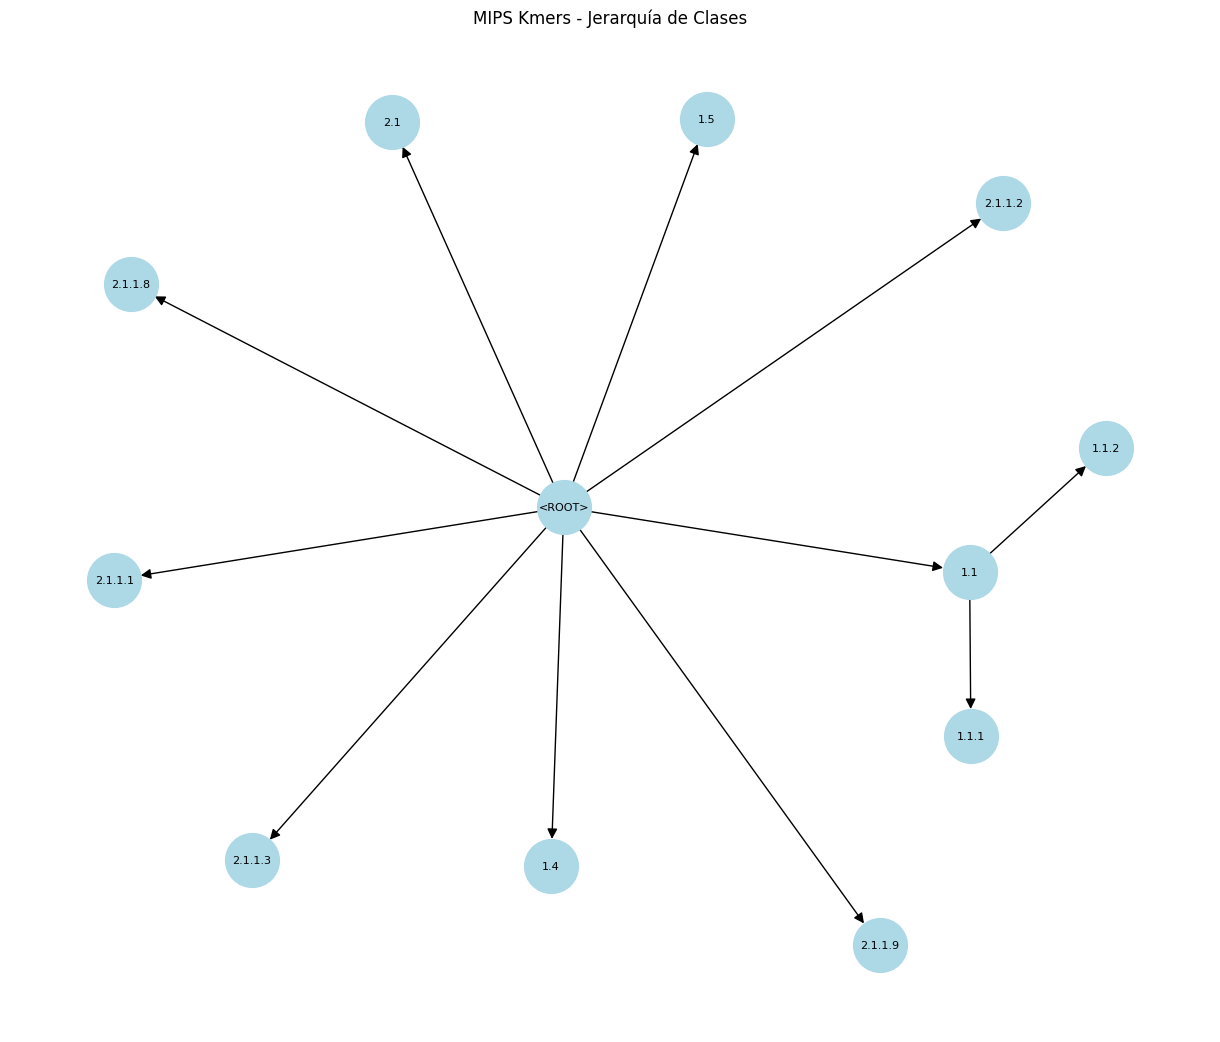

Entrenando Hierarchical SVM en MIPS Kmers...
Hierarchical SVM en MIPS Kmers:
  Accuracy: 0.6325
  F1 Jerárquico: 0.8172
  Precisión Jerárquica: 0.7653
  Recall Jerárquico: 0.8767
Entrenando Hierarchical Random Forest en MIPS Kmers...
Hierarchical Random Forest en MIPS Kmers:
  Accuracy: 0.6587
  F1 Jerárquico: 0.8338
  Precisión Jerárquica: 0.7791
  Recall Jerárquico: 0.8968

Procesando dataset: MIPS Pseudo


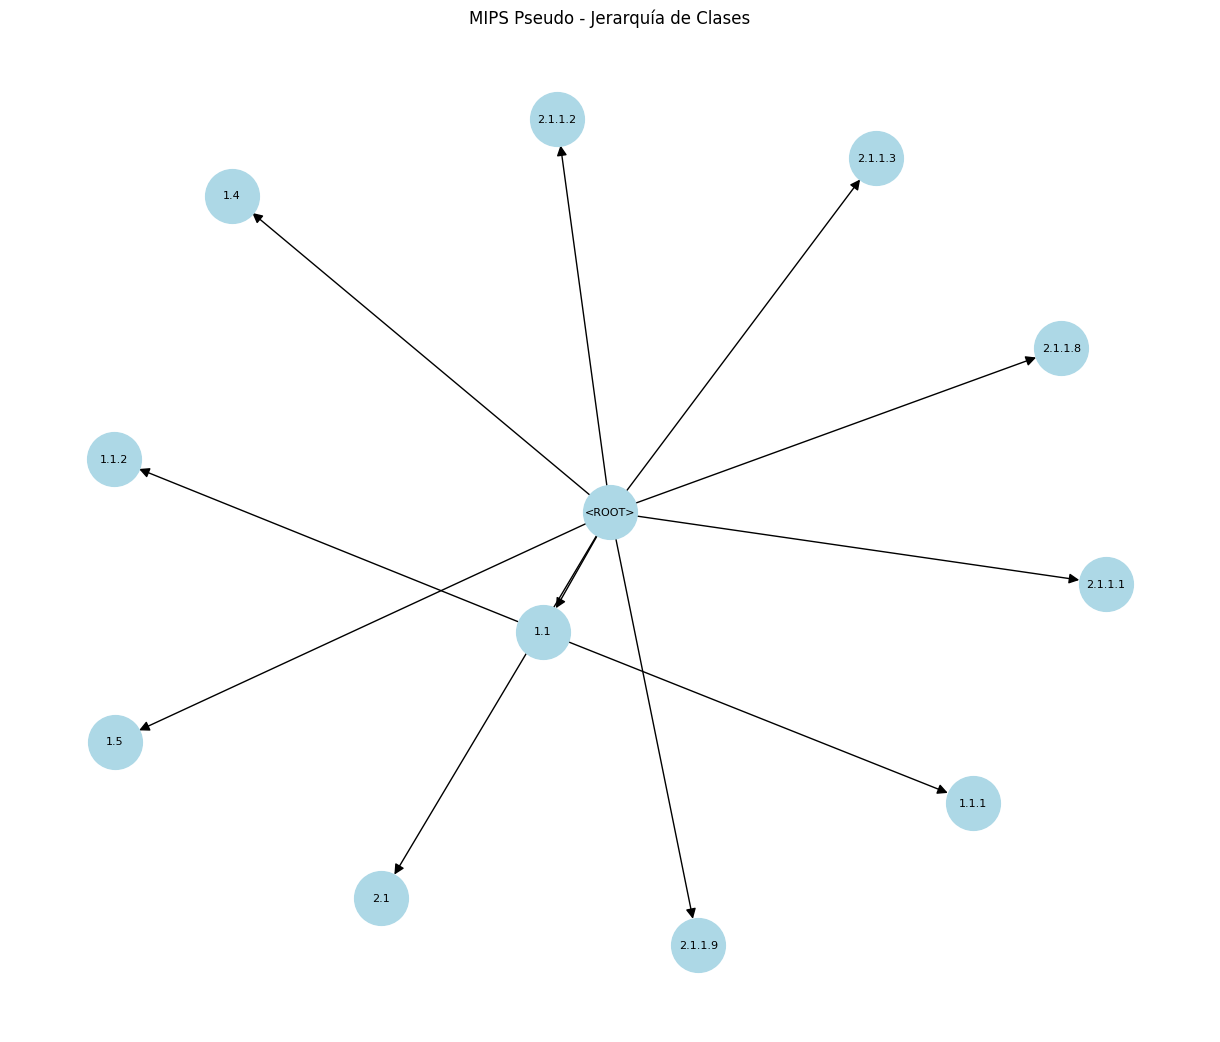

Entrenando Hierarchical SVM en MIPS Pseudo...
Hierarchical SVM en MIPS Pseudo:
  Accuracy: 0.6182
  F1 Jerárquico: 0.8077
  Precisión Jerárquica: 0.7534
  Recall Jerárquico: 0.8704
Entrenando Hierarchical Random Forest en MIPS Pseudo...
Hierarchical Random Forest en MIPS Pseudo:
  Accuracy: 0.6546
  F1 Jerárquico: 0.8305
  Precisión Jerárquica: 0.7748
  Recall Jerárquico: 0.8947

Procesando dataset: Repbase Kmers


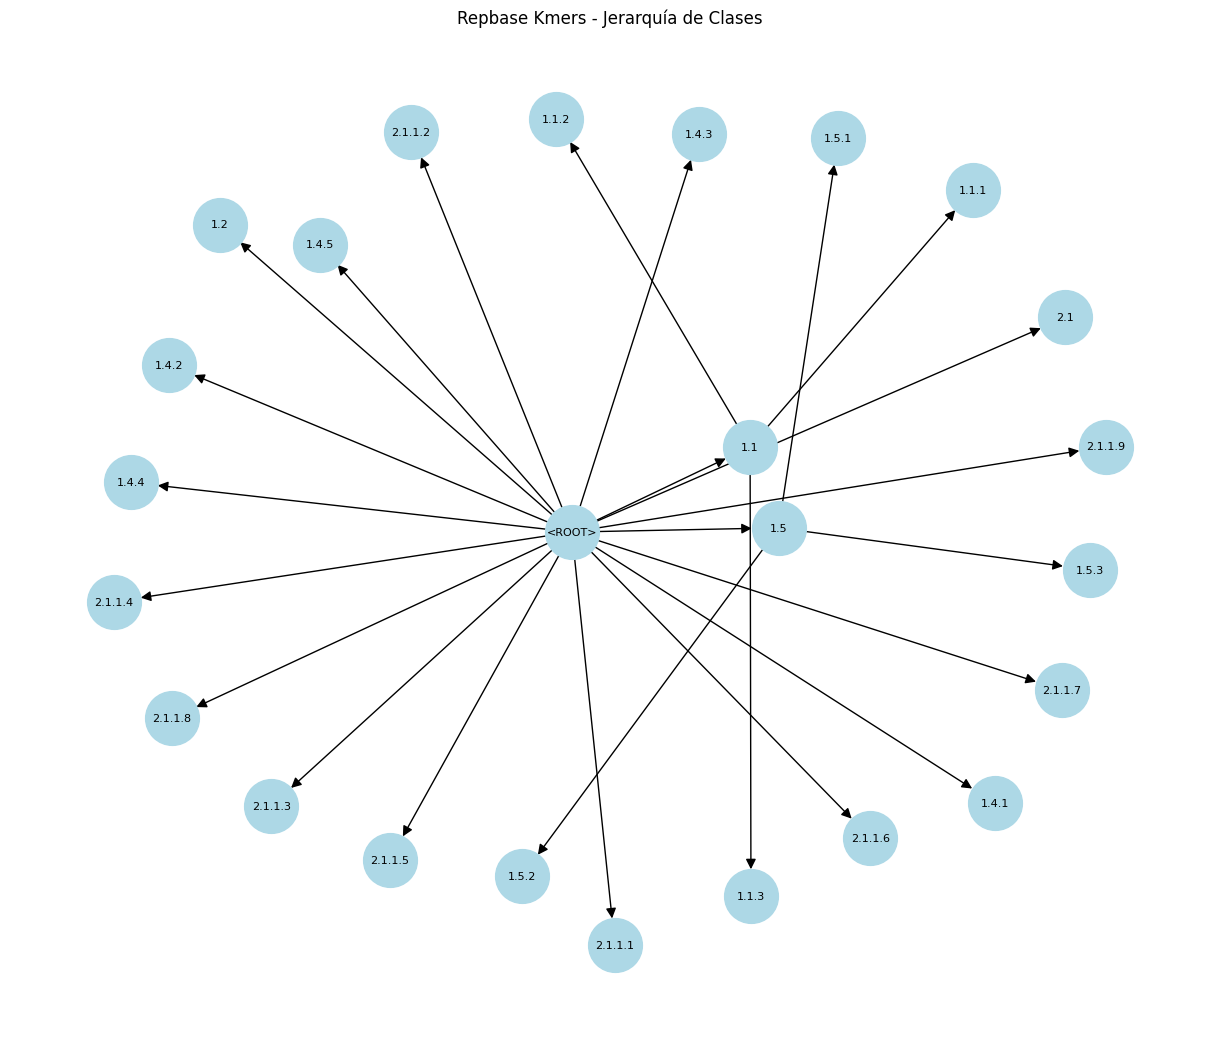

Entrenando Hierarchical SVM en Repbase Kmers...
Hierarchical SVM en Repbase Kmers:
  Accuracy: 0.5007
  F1 Jerárquico: 0.6266
  Precisión Jerárquica: 0.5879
  Recall Jerárquico: 0.6707
Entrenando Hierarchical Random Forest en Repbase Kmers...
Hierarchical Random Forest en Repbase Kmers:
  Accuracy: 0.5938
  F1 Jerárquico: 0.6981
  Precisión Jerárquica: 0.6654
  Recall Jerárquico: 0.7342


In [4]:
print("Iniciando experimentos de clasificación jerárquica...")
all_datasets = load_datasets()
results = {}

for dataset_name, (X, y) in all_datasets.items():
    print(f"\nProcesando dataset: {dataset_name}")
    X_train, X_test, y_train, y_test = preprocess_dataset(X, y)
    class_hierarchy = build_class_hierarchy(y_train)

    # Visualización de la jerarquía
    visualize_hierarchy(class_hierarchy, f"{dataset_name} - Jerarquía de Clases")

    # Entrenamiento y evaluación SVM
    hsvm_results = train_evaluate_hsvm(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name)

    # Entrenamiento y evaluación Random Forest
    hrf_results = train_evaluate_hrf(X_train, X_test, y_train, y_test, class_hierarchy, dataset_name)

    results[dataset_name] = {
        "HSVM": hsvm_results,
        "HRF": hrf_results
    }


## 4. Comparación de resultados
Para cada uno de los **datasets** probados, se comparan las métricas de *Accuracy*, *F1 Jerárquico*, *Precisión Jerárquica* y *Recall Jerárquico* de los dos algoritmos.

En las gráficas de barras se pueden observar las diferencias entre los métodos:



Generando gráficas de comparación...


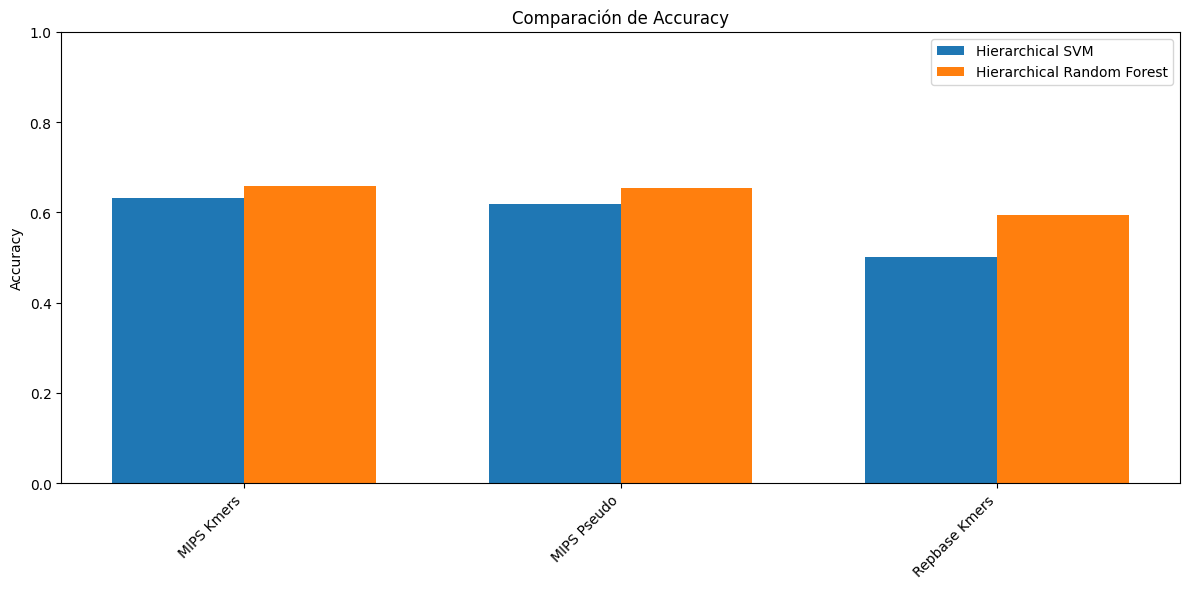

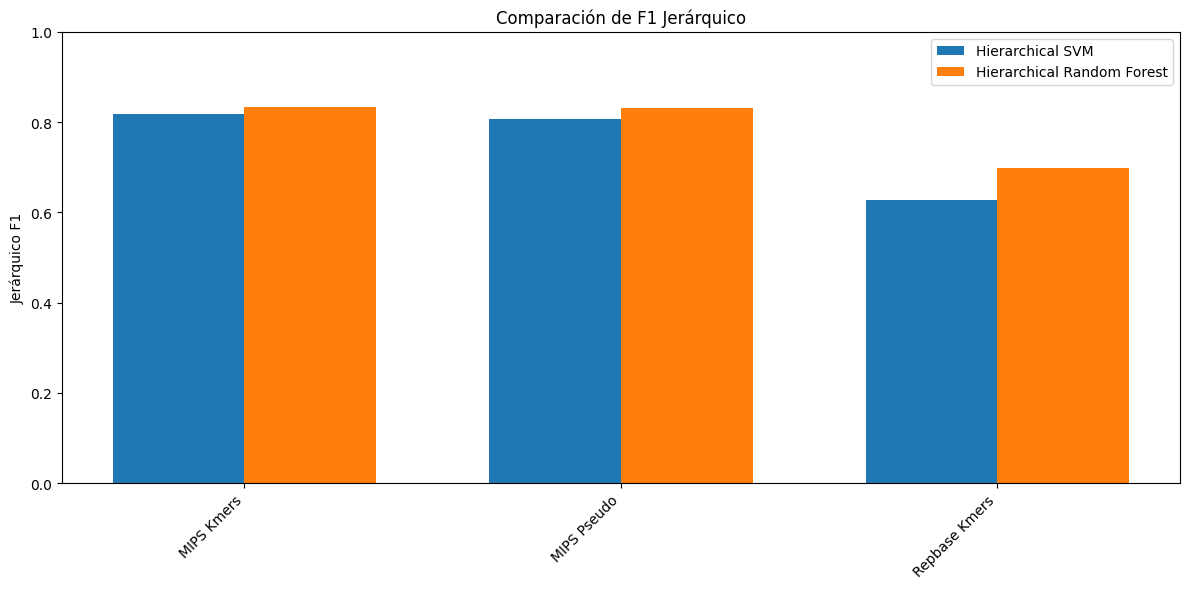

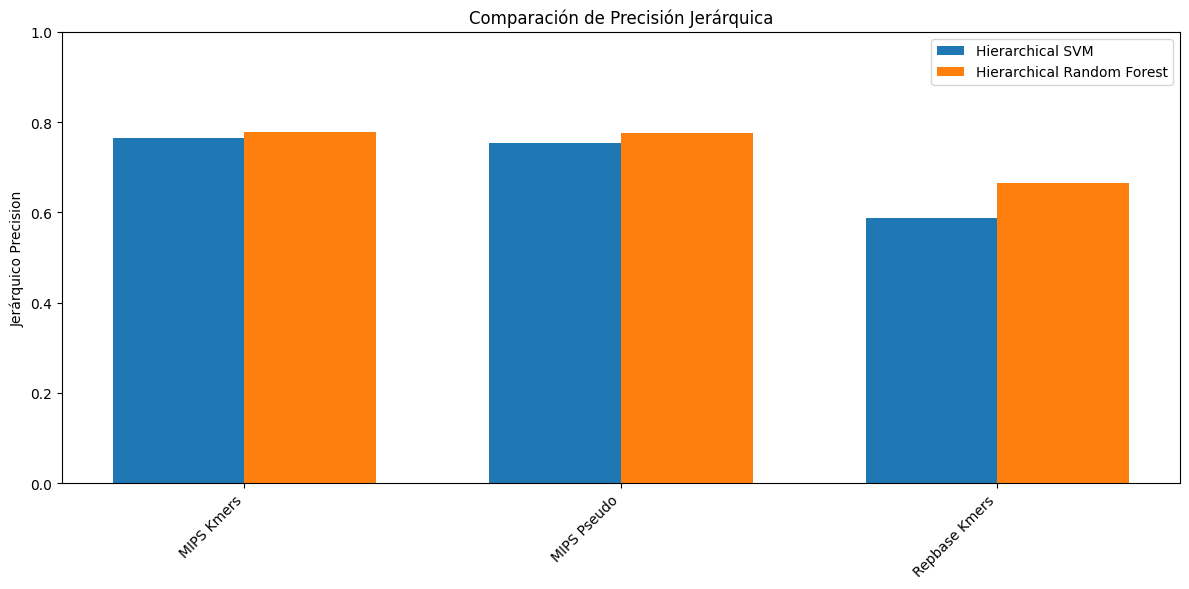

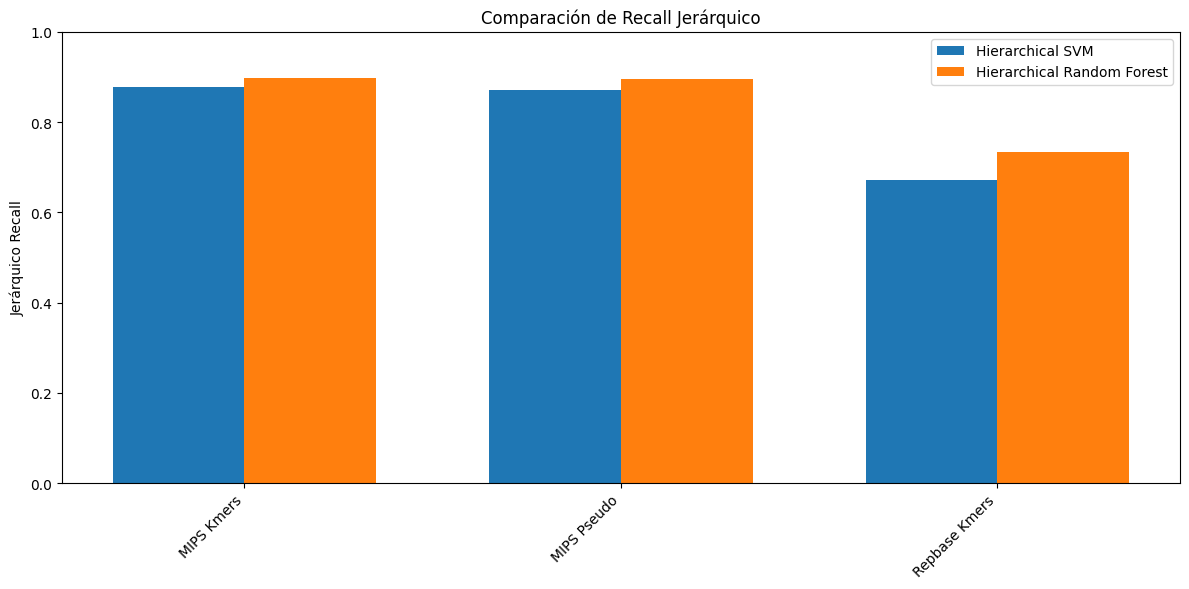

In [5]:
print("\nGenerando gráficas de comparación...")
plot_metric_comparison(results, 'accuracy', 'Comparación de Accuracy')
plot_metric_comparison(results, 'h_f1', 'Comparación de F1 Jerárquico')
plot_metric_comparison(results, 'h_precision', 'Comparación de Precisión Jerárquica')
plot_metric_comparison(results, 'h_recall', 'Comparación de Recall Jerárquico')

## 5. Resumen de resultados y conclusiones
A continuación, se muestra un resumen numérico de los resultados y se discuten las principales conclusiones:
1. **Comparación de Algoritmos**: Se observa qué algoritmo obtiene mejores métricas en promedio.
2. **Dificultad de los Datasets**: Cuáles son más complicados, según las métricas globales.
3. **Métricas Jerárquicas**: Qué tan bien capturan la estructura jerárquica en comparación con la métrica de *accuracy* convencional.
4. **Conclusiones Globales**: Recomendaciones finales acerca de cuál método se comporta mejor y en qué casos.

In [6]:
print("\n=== RESUMEN DE RESULTADOS ===")
# 1. Comparación de Algoritmos
datasets_list = list(results.keys())
avg_hsvm_acc = np.mean([results[d]["HSVM"]["accuracy"] for d in results])
avg_hsvm_f1 = np.mean([results[d]["HSVM"]["h_f1"] for d in results])
avg_hrf_acc = np.mean([results[d]["HRF"]["accuracy"] for d in results])
avg_hrf_f1 = np.mean([results[d]["HRF"]["h_f1"] for d in results])

print("1. Rendimiento por Algoritmo y Dataset:")
for d in datasets_list:
    hsvm_acc = results[d]["HSVM"]["accuracy"]
    hsvm_f1 = results[d]["HSVM"]["h_f1"]
    hrf_acc = results[d]["HRF"]["accuracy"]
    hrf_f1 = results[d]["HRF"]["h_f1"]
    print(f" - {d}")
    print(f"   HSVM: Accuracy={hsvm_acc:.4f}, F1j={hsvm_f1:.4f}")
    print(f"   HRF:  Accuracy={hrf_acc:.4f}, F1j={hrf_f1:.4f}")

print("\n2. Promedios Globales:")
print(f" - HSVM: Accuracy promedio={avg_hsvm_acc:.4f}, F1j promedio={avg_hsvm_f1:.4f}")
print(f" - HRF:  Accuracy promedio={avg_hrf_acc:.4f}, F1j promedio={avg_hrf_f1:.4f}")

# 2. Análisis de dificultad de los Datasets
hsvm_accs = [results[d]["HSVM"]["accuracy"] for d in datasets_list]
hrf_accs = [results[d]["HRF"]["accuracy"] for d in datasets_list]
avg_accs = [(a + b)/2 for a, b in zip(hsvm_accs, hrf_accs)]
dataset_difficulty = list(zip(datasets_list, avg_accs))
dataset_difficulty.sort(key=lambda x: x[1])

print("\n3. Datasets ordenados por dificultad (mayor dificultad = menor accuracy promedio):")
for ds, acc in dataset_difficulty:
    print(f" - {ds}: Accuracy promedio = {acc:.4f}")

# 3. Conclusiones sobre métricas jerárquicas
print("\n4. Métricas Jerárquicas:")
for d in datasets_list:
    hsvm_h_prec = results[d]["HSVM"]["h_precision"]
    hsvm_h_rec = results[d]["HSVM"]["h_recall"]
    hrf_h_prec = results[d]["HRF"]["h_precision"]
    hrf_h_rec = results[d]["HRF"]["h_recall"]
    print(f" - {d}:")
    print(f"   HSVM: Prec. jerárq={hsvm_h_prec:.4f}, Recall jerárq={hsvm_h_rec:.4f}")
    print(f"   HRF:  Prec. jerárq={hrf_h_prec:.4f}, Recall jerárq={hrf_h_rec:.4f}")

print("\n5. Conclusiones globales:")
# Comparación general de accuracy
if avg_hsvm_acc > avg_hrf_acc:
    print(" - El método HSVM obtiene mejor accuracy en promedio.")
elif avg_hrf_acc > avg_hsvm_acc:
    print(" - El método HRF obtiene mejor accuracy en promedio.")
else:
    print(" - Ambos métodos tienen resultados muy similares en accuracy promedio.")

# Comparación general de F1 jerárquico
if avg_hsvm_f1 > avg_hrf_f1:
    print(" - HSVM parece capturar mejor la estructura jerárquica, gracias a un F1 jerárquico promedio más alto.")
elif avg_hrf_f1 > avg_hsvm_f1:
    print(" - HRF parece capturar mejor la estructura jerárquica, gracias a un F1 jerárquico promedio más alto.")
else:
    print(" - Ambos métodos tienen F1 jerárquico muy similar en promedio.")

print("\n - En general, la elección de un método podría depender de las características del dataset.")
print(" - Se recomienda probar ambos clasificadores cuando se aborde un nuevo problema de clasificación jerárquica.")



=== RESUMEN DE RESULTADOS ===
1. Rendimiento por Algoritmo y Dataset:
 - MIPS Kmers
   HSVM: Accuracy=0.6325, F1j=0.8172
   HRF:  Accuracy=0.6587, F1j=0.8338
 - MIPS Pseudo
   HSVM: Accuracy=0.6182, F1j=0.8077
   HRF:  Accuracy=0.6546, F1j=0.8305
 - Repbase Kmers
   HSVM: Accuracy=0.5007, F1j=0.6266
   HRF:  Accuracy=0.5938, F1j=0.6981

2. Promedios Globales:
 - HSVM: Accuracy promedio=0.5838, F1j promedio=0.7505
 - HRF:  Accuracy promedio=0.6357, F1j promedio=0.7875

3. Datasets ordenados por dificultad (mayor dificultad = menor accuracy promedio):
 - Repbase Kmers: Accuracy promedio = 0.5472
 - MIPS Pseudo: Accuracy promedio = 0.6364
 - MIPS Kmers: Accuracy promedio = 0.6456

4. Métricas Jerárquicas:
 - MIPS Kmers:
   HSVM: Prec. jerárq=0.7653, Recall jerárq=0.8767
   HRF:  Prec. jerárq=0.7791, Recall jerárq=0.8968
 - MIPS Pseudo:
   HSVM: Prec. jerárq=0.7534, Recall jerárq=0.8704
   HRF:  Prec. jerárq=0.7748, Recall jerárq=0.8947
 - Repbase Kmers:
   HSVM: Prec. jerárq=0.5879, Reca